In [32]:
!pip install mxnet-cu91

spacy 2.0.13 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1.post2 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['pikachu', 'imgpichacu', 'gluonbook']


In [34]:
import mxnet as mx

In [35]:
print(mx.__version__)

1.2.1


In [36]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
from input import gluonbook as gb
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time


In [37]:
ctx = gb.try_gpu()

In [38]:
ctx

gpu(0)

In [39]:
def cls_predictor(num_anchors,num_classes):
    return nn.Conv2D(channels=num_anchors*(num_classes+1),kernel_size=3,padding=1)

In [40]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(channels=num_anchors*4,kernel_size=3,padding=1)

In [41]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),nn.Activation('relu'),
           nn.Conv2D(channels=num_channels//2,kernel_size=1,strides=1),
            nn.BatchNorm(),nn.Activation('relu'),
           nn.Conv2D(channels=num_channels,kernel_size=3,strides=1,padding=1))
    
    blk.add(nn.MaxPool2D(pool_size=2))
    return blk

In [42]:
def vgg_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.BatchNorm(),
                nn.Activation('relu'),
                nn.Conv2D(channels=num_channels,kernel_size=3,strides=1,padding=1))
    blk.add(nn.BatchNorm(),nn.Activation('relu'),
            nn.Conv2D(channels=num_channels,kernel_size=1,strides=1))
    blk.add(nn.MaxPool2D(pool_size=2,strides=2))
    
    return blk

In [43]:
def vgg_16():
    vgg_16 = nn.Sequential()
    conv = (32,64,128,256,512,512)
    vgg_16.add(nn.BatchNorm(),nn.Activation('relu'),
              nn.Conv2D(channels=conv[0],kernel_size=7,strides=1,padding=3),
              nn.BatchNorm(),nn.Activation('relu'),
              nn.Conv2D(channels=conv[0],kernel_size=3,strides=1,padding=1))   
    #vgg_16.add(nn.MaxPool2D(pool_size=2,strides=2))    
    for i in range(3):
        vgg_16.add(vgg_blk(conv[i+1]))
    
    #最后两层换成卷积
    vgg_16.add(nn.BatchNorm(),nn.Activation('relu'),
               nn.Conv2D(channels=conv[4],kernel_size=3,strides=1,padding=1),
               nn.BatchNorm(),nn.Activation('relu'),
               nn.Conv2D(channels=conv[5],kernel_size=1))
    
    return vgg_16

In [44]:
#把通道数换到最后
def flatten_pred(pred):
    return pred.transpose((0,2,3,1)).flatten()

def concat_pred(preds):
    return nd.concat(*[flatten_pred(pred) for pred in preds],dim=1)

In [45]:
def blk_forward(net,X,sizes,ratios,cls_predictor,bbox_predictor):
    #首先计算这一层的输出
    Y = net(X)
    #生成默认锚框
    anchors = contrib.nd.MultiBoxPrior(Y,sizes=sizes,ratios=ratios)
    #进行预测
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    #输出生成的默认锚框，类别预测，偏移量预测
    return (Y,anchors,cls_preds,bbox_preds)

In [46]:
def get_blk(i):
    if i==0:
        return vgg_16()
    elif i==4:
        return nn.GlobalMaxPool2D()
    else:
        return down_sample_blk(256)

In [47]:
class SSD(nn.Block):
    def __init__(self,num_classes,**kwargs):
        super(SSD,self).__init__(**kwargs)
        self.num_classes = num_classes           #需要预测的总类别数
        self.sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
                      [0.88, 0.961]]
        self.ratios = [[0.35, 1.5, 0.75]] * 5                      #超参数，每一层我们需要生成的锚框宽高比和大小比例
        #下面定义每一层的网络
        for i in range(5):
            #这一层的每个像素的锚框个数
            num_anchors = len(self.sizes[i])+len(self.ratios[i])-1
            #卷积层
            setattr(self,'blk_%d' % i,get_blk(i))
            #类别预测
            setattr(self,'cls_pred_%d' % i,cls_predictor(num_anchors,num_classes))
            #锚框偏移量预测
            setattr(self,'bbox_pred_%d' % i ,bbox_predictor(num_anchors))
    
    def forward(self,X):
        #前向运算函数
        anchors,cls_preds,bbox_preds= [],[],[]
        
        for i in range(5):
            #进行一次前向运算
            X,anchor,cls_pred,bbox_pred = blk_forward(getattr(self,'blk_%d' % i),X,self.sizes[i],self.ratios[i],
                                                     getattr(self,'cls_pred_%d' % i),
                                                     getattr(self,'bbox_pred_%d' % i))
            #将输出追加到结果中
            anchors.append(anchor)
            cls_preds.append(cls_pred)
            bbox_preds.append(bbox_pred)
        #最后将结果输出
        return(nd.concat(*anchors,dim=1),
               concat_pred(cls_preds).reshape((0,-1,self.num_classes+1)),
               concat_pred(bbox_preds))

In [48]:
class smooth_L1Loss(gloss.Loss):
    def __init__(self,sigma=0.5,weight=None,batch_axis=0,data_axis=-1,**kwargs):
        super(smooth_L1Loss,self).__init__(weight,batch_axis,**kwargs)
        self.axis = data_axis
        self._sigma = sigma
       
    #loss里面有很多函数可以自己来定义loss
    def hybrid_forward(self,F,pred,label,sample_weight=None): 
        loss = F.smooth_l1((pred-label),scalar=self._sigma)
        loss = gluon.loss._apply_weighting(F,loss,self._weight,sample_weight)
        return F.mean(loss,axis = self._batch_axis,exclude =True)

In [49]:
class focal_SoftMaxCrossEntropy(gloss.Loss):
    def __init__(self,gamma=2.0,data_axis=-1,batch_axis=0,
                sparse_label = True,from_logits = False,eps =1e-5,weight=None,**kwargs):
        super(focal_SoftMaxCrossEntropy,self).__init__(weight,batch_axis,**kwargs)
        self._gamma = 2.0
        self._axis = data_axis
        self._sparse_label = sparse_label
        self._from_logits = from_logits
        self._eps = eps
    
    def hybrid_forward(self,F,pred,label,smaple_weight = None):
        if not self._from_logits:
            #计算一次softmax
            pred = F.softmax(pred,axis = self._axis)
        if self._sparse_label:
            #这里keep_dim是为了后面与 smaple_weight相乘
            pred = nd.pick(pred,label,axis=self._axis,keepdims=True)
            loss = -((1-pred)**self._gamma)*F.log(pred+self._eps)
        loss  = gluon.loss._apply_weighting(F,loss,self._weight,smaple_weight)
        return F.mean(loss,axis = self._batch_axis,exclude=True)       

In [50]:
tiny_SSD = SSD(num_classes=1)
ctx = gb.try_gpu()
ctx

gpu(0)

In [51]:
tiny_SSD.initialize(init = init.Xavier(),ctx=ctx)
trainer = gluon.Trainer(tiny_SSD.collect_params(),'sgd',{'learning_rate':0.2,'wd':5e-4})

In [52]:
def cls_eval(cls_pred,cls_label):
    return (cls_pred.argmax(axis=-1)==cls_label).mean().asscalar()

def bbox_eval(bbox_pred,bbox_label,bbox_mask):
    return (bbox_pred*bbox_mask-bbox_label*bbox_mask).abs().mean().asscalar()


In [53]:
smooth_L1 = smooth_L1Loss()
focal_loss = focal_SoftMaxCrossEntropy()

In [54]:
batch_size = 16
train_iter,test_iter =gb.load_data_pikachu(batch_size)
train_iter.reshape(label_shape=(3,5))

In [55]:
def train(num_epoches):
    for epoch in range(num_epoches):
        start = time.time()
        train_cls_acc = 0
        train_bbox_loss = 0
        train_iter.reset()

        for i,batch in enumerate(train_iter):
            #获取小批量数据
            X = batch.data[0].as_in_context(ctx)
            Y = batch.label[0].as_in_context(ctx)
            with autograd.record():
                #前向运算
                anchors,cls_preds,bbox_preds = tiny_SSD(X)
                #标记锚框获得标签,这里还可以设置负采样
                bbox_labels,bbox_masks,cls_labels= contrib.nd.MultiBoxTarget(anchors,Y,cls_preds.transpose((0,2,1)))
                #计算损失
                l_cls = focal_loss(cls_preds,cls_labels)
                l_bbox = smooth_L1(bbox_preds*bbox_masks,bbox_labels*bbox_masks)
                l_total = l_cls+l_bbox
            #反向传播
            l_total.backward()
            #迭代参数
            trainer.step(batch_size)
            train_cls_acc += cls_eval(cls_preds,cls_labels)
            train_bbox_loss += bbox_eval(bbox_preds,bbox_labels,bbox_masks)
        #训练完epoch输出结果
        print('epoch %2d , train_cls_acc %.2f , bbox mae %.2e , time %.1f sec' %
             (epoch+1,train_cls_acc/(i+1),train_bbox_loss/(i+1),time.time()-start))

In [56]:
train(1)

epoch  1 , train_cls_acc 0.99 , bbox mae 4.55e-03 , time 69.7 sec


In [ ]:
#读取图片
img = image.imread('../input/imgpichacu/pikachu.jpg')
feature = image.imresize(img,256,256).astype('float32')
X = feature.transpose((2,0,1))
X = X.expand_dims(axis=0)


In [58]:
def predict(X):
    #前线运算
    anchors,cls_preds,bbox_preds = tiny_SSD(X.as_in_context(ctx))
    cls_probs = nd.softmax(cls_preds).transpose((0,2,1))
    output = contrib.nd.MultiBoxDetection(cls_probs,bbox_preds,anchors)
    idx = [i for i,row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0,idx]


def display(img,output,threshold):
    fig = gb.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h,w = img.shape[0:2]
        bbox = [row[2:6]*nd.array((w,h,w,h),ctx=row.context)]
        gb.show_bboxes(fig.axes,bbox,'pikachu %.2f'% score,'w')

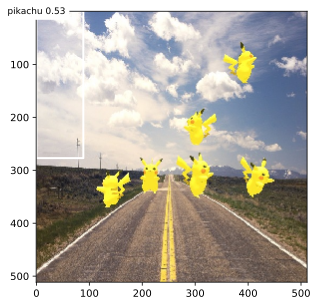

In [59]:
output = predict(X)
gb.set_figsize((5,5))
display(img,output,threshold=0.5)